# Lithium Oven Optic 6

In [1]:
import sys
import os
sys.path.insert(0, "../../python")

import numpy as np
from numpy.fft import fft, ifft, fftfreq, fftshift
from scipy.integrate import simps
from scipy.interpolate import interp1d
from scipy.special import erf
from beam.beams import laserpulse
from beam.beams import laserbeam
from beam.elements import plasma
from beam.elements import optic
from beam import interactions
from ionization import ionization
from lens import profile
from lens import bessel
from lens import ray
import matplotlib.pyplot as plt
from lens import design
plt.style.use('notes')
%load_ext autoreload
%autoreload 2

path = '/mnt/md0/Data/rariniello/Lithium_Oven/Lithium_Oven_Optic_6/'
lam = 0.796
# All length units are in um

Test optic 6 is the first prototype we actually plan on making so the optics have to be defined to fit in FACET II's experimantal area but also work with our laser for testing. This notebook contains the detailed designs for the optics as well as simulations of the beam dump.

In [2]:
r = np.load(path+'r.npy')
E = np.load(path+'e.npy')
plasma = np.load(path+'plasma.npy')

Nx = 2**10
X = 10e3
tau = 30
pulseParams = {
    'Nt' : 2**6,
    'Nx' : Nx,
    'Ny' : Nx,
    'X' : X,
    'Y' : X,
    'T' : 3*tau,
    'lam' : lam,
    'path' : path,
    'load' : True,
    'threads' : 4,
    'cyl' : True,
    'tau' : tau,
    'name' : 'Refracted_Beam',
}
pulse = laserpulse.Pulse(pulseParams)

In [3]:
# Beam intensity downstream
Nx = 2**10
X = 20e3
pulseParams['name'] = 'Post_Plasma'
pulseParams['Nx'] = Nx
pulseParams['Ny'] = Nx
pulseParams['X'] = X
pulseParams['Y'] = X
pulseParams['load'] = False
pulse1 = laserpulse.Pulse(pulseParams)
e0 = np.array(pulse.e)
e = pulse1.e
for i in range(pulse.Nt):
    e[i, :, :] = pulse1.reconstruct_from_cyl(pulse.x, e0[i, :, int(pulse.Ny/2)], pulse1.x, pulse1.y)
pulse1.initialize_field(e)

In [4]:
# Propagate to the holed mirror
Nz = 200
Z = 0.85e6
z = np.linspace(0, Z, Nz)
pulse1.propagate(z, 1.0)

In [5]:
I1 = np.zeros((Nz, Nx), dtype='double')
for i in range(Nz):
    I1[i, :] = np.amax(pulse1.intensity_from_field(pulse1.load_field(i)[0]), axis=0)
I1 = pulse1.prep_data(I1)

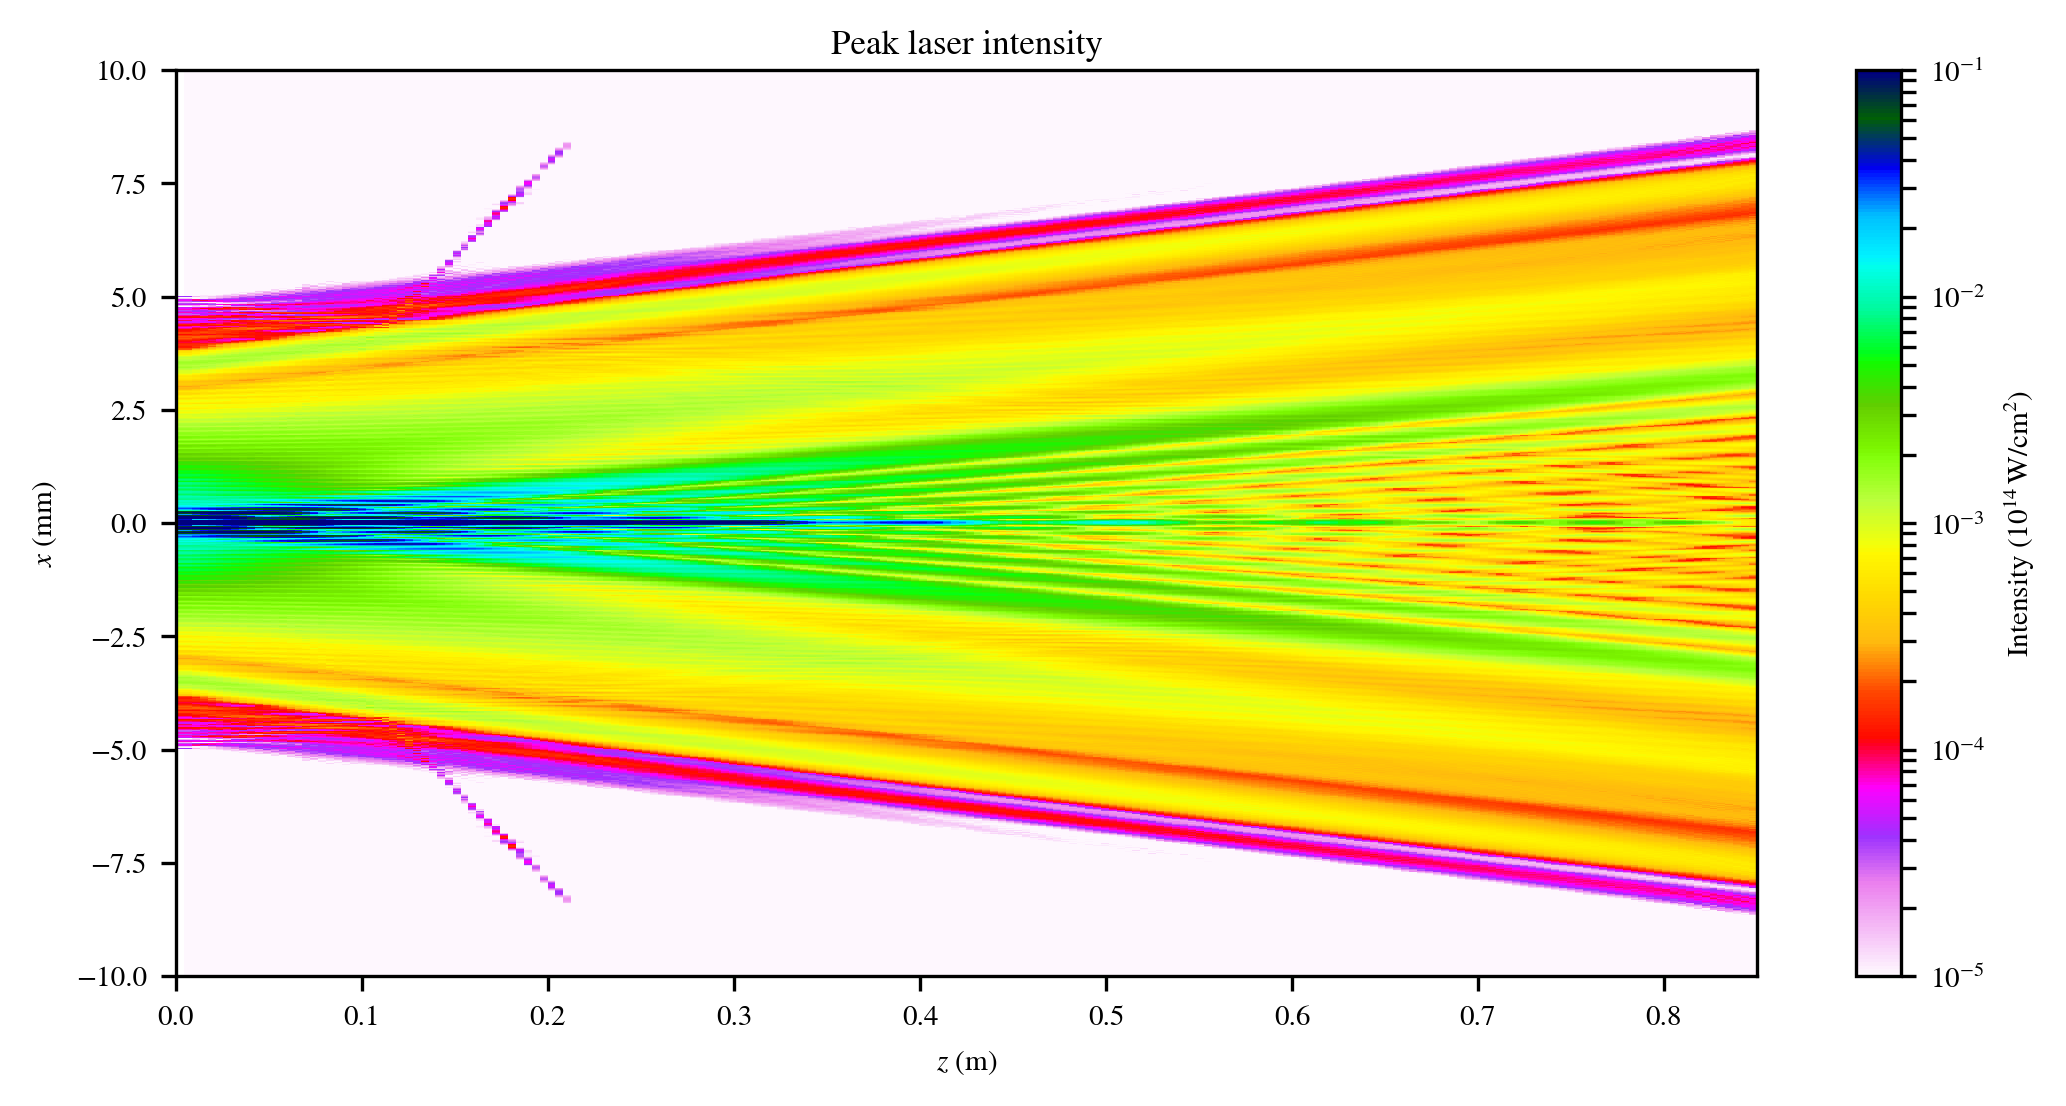

In [6]:
import matplotlib.colors as colors
plt.figure(figsize=(8.5, 4), dpi=300)
norm = colors.LogNorm(vmin=1e-5, vmax=0.1)
im = plt.imshow(I1, aspect='auto', extent=[0, Z/1e6, -X/2e3, X/2e3], norm=norm)
cb = plt.colorbar()
cb.set_label(r'Intensity ($10^{14}\,\mathrm{W/cm^2}$)')
plt.set_cmap('gist_ncar_r')
plt.xlabel(r'$z$ (m)')
plt.ylabel(r'$x$ (mm)')
plt.title('Peak laser intensity')
plt.show()

In [7]:
# Reflect off of the mirror and propagate to the dump
# Create a new beam with the same intensity
Nx = 2**10
X = 40e3
pulseParams['name'] = 'Dumped_Beam'
pulseParams['Nx'] = Nx
pulseParams['Ny'] = Nx
pulseParams['X'] = X
pulseParams['Y'] = X
pulse_dump = laserpulse.Pulse(pulseParams)
e0 = np.array(pulse1.e)
e = pulse_dump.e
for i in range(pulse1.Nt):
    e[i, :, :] = pulse_dump.reconstruct_from_cyl(pulse1.x, e0[i, :, int(pulse1.Ny/2)], pulse_dump.x, pulse_dump.y)
pulse_dump.initialize_field(e)

In [8]:
# Reflect off of the mirror and out towards the dump
mirrorParams = {
    'r_in' : 1e3,
    'r_out' : 75e3,
    'Nx' : pulse_dump.Nx,
    'Ny' : pulse_dump.Nx,
    'X' : pulse_dump.X,
    'Y' : pulse_dump.X,
    'path' : path, 
    'name' : 'Dump_Mirror',
    'lam' : lam,
    'load' : False
}
mirror = optic.Annulus(mirrorParams)

In [9]:
interactions.beam_intensity(pulse_dump, mirror)

In [10]:
# Propagate 2m past the holed mirror
Nz = 200
Z = 2e6
z = np.linspace(0, Z, Nz)
pulse_dump.propagate(z, 1.0)

In [11]:
Idump = np.zeros((Nz, Nx), dtype='double')
for i in range(Nz):
    Idump[i, :] = np.amax(pulse_dump.intensity_from_field(pulse_dump.load_field(i+1)[0]), axis=0)
Idump = pulse_dump.prep_data(Idump)

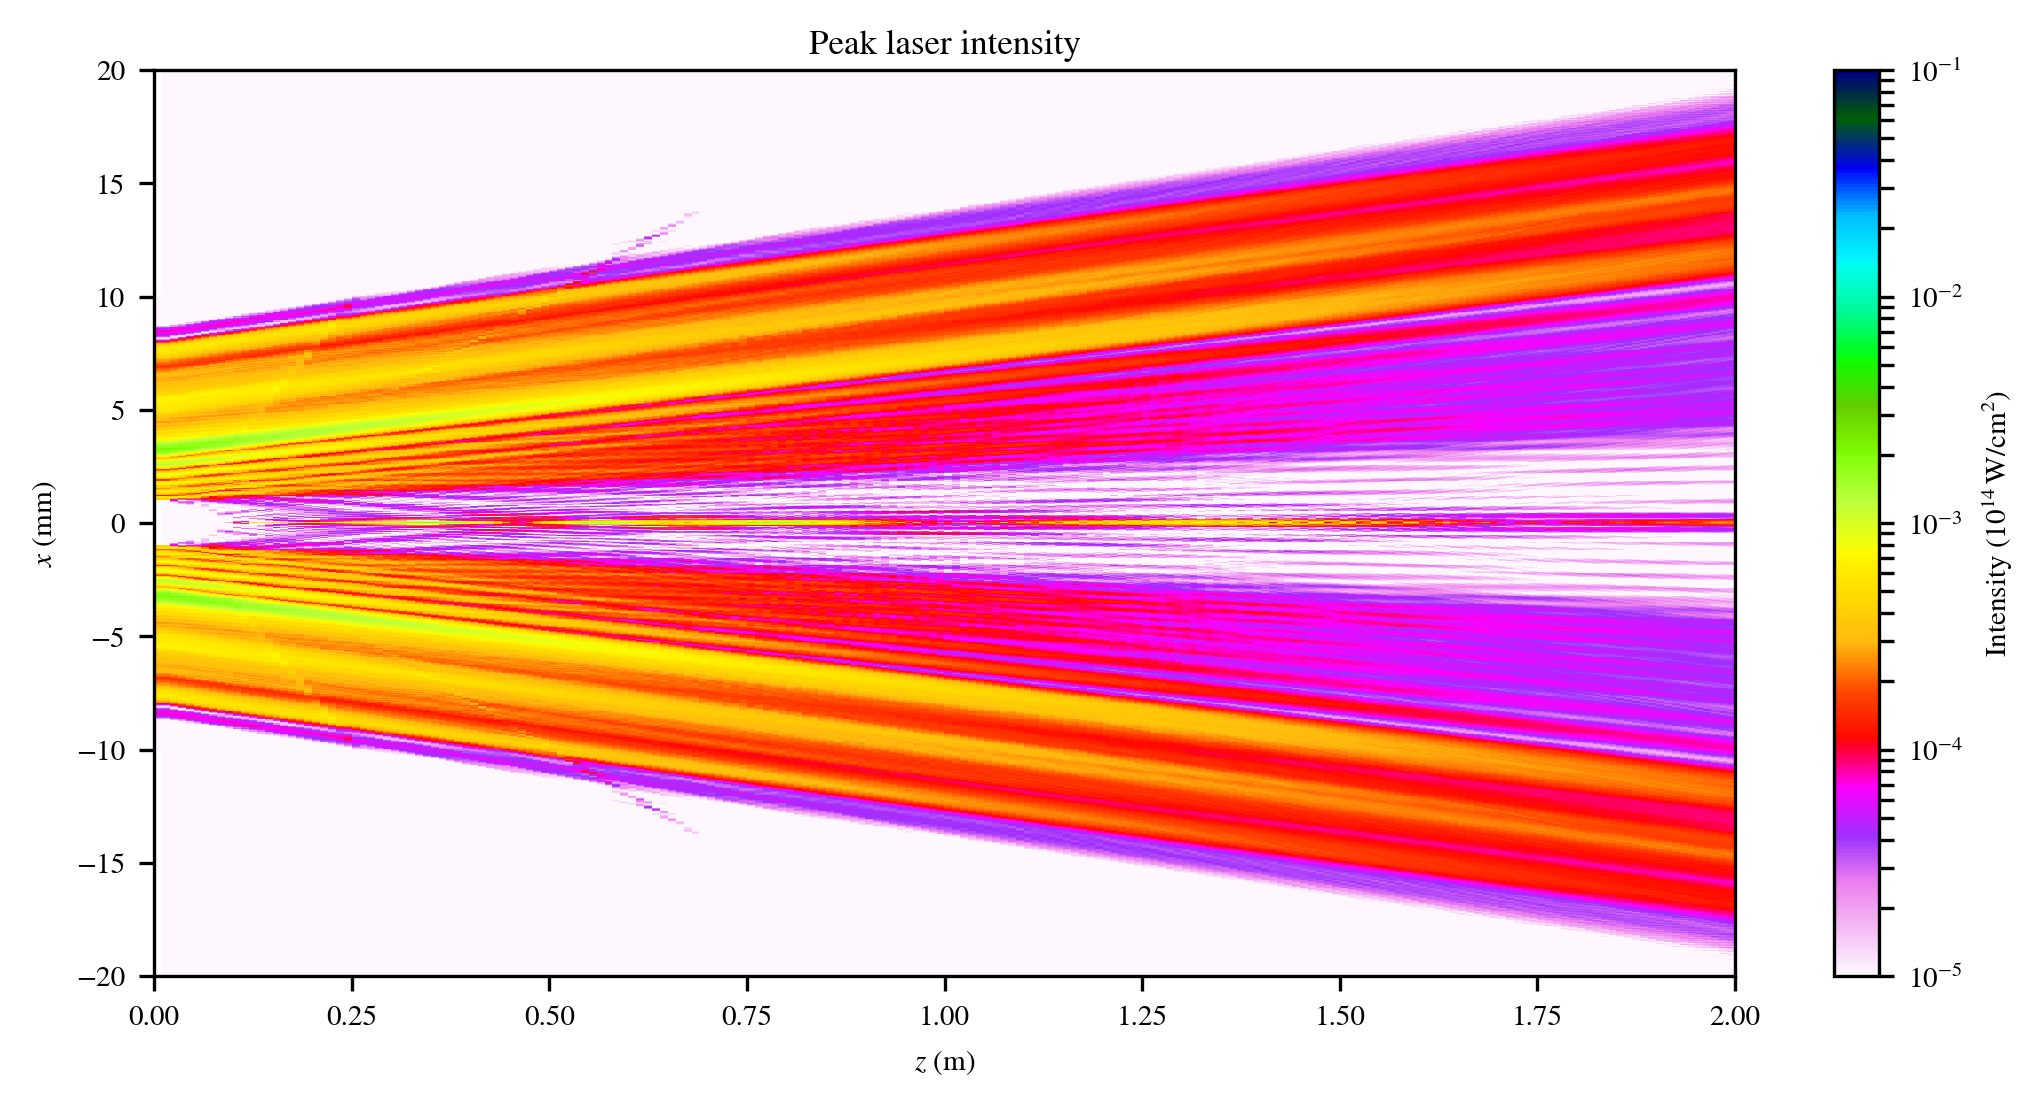

In [12]:
import matplotlib.colors as colors
plt.figure(figsize=(8.5, 4), dpi=300)
norm = colors.LogNorm(vmin=1e-5, vmax=0.1)
im = plt.imshow(Idump, aspect='auto', extent=[0, Z/1e6, -pulse_dump.X/2e3, pulse_dump.X/2e3], norm=norm)
cb = plt.colorbar()
cb.set_label(r'Intensity ($10^{14}\,\mathrm{W/cm^2}$)')
plt.set_cmap('gist_ncar_r')
plt.xlabel(r'$z$ (m)')
plt.ylabel(r'$x$ (mm)')
plt.title('Peak laser intensity')
plt.show()

In [13]:
# Continue to propagate through the accelerator
holeParams = {
    'r' : 1e3,
    'Nx' : pulse1.Nx,
    'Ny' : pulse1.Nx,
    'X' : pulse1.X,
    'Y' : pulse1.X,
    'path' : path, 
    'name' : 'Dump_Mirror_Hole',
    'lam' : lam,
    'load' : False
}
hole = optic.Aperture(holeParams)

In [14]:
interactions.beam_intensity(pulse1, hole)

In [15]:
# Propagate 2m past the holed mirror
Nz = 200
Z = 2e6
z = np.linspace(0, Z, Nz)
pulse1.propagate(z, 1.0)

In [16]:
I2 = np.zeros((Nz, Nx), dtype='double')
for i in range(Nz):
    I2[i, :] = np.amax(pulse1.intensity_from_field(pulse1.load_field(i+Nz+1)[0]), axis=0)
I2 = pulse1.prep_data(I2)

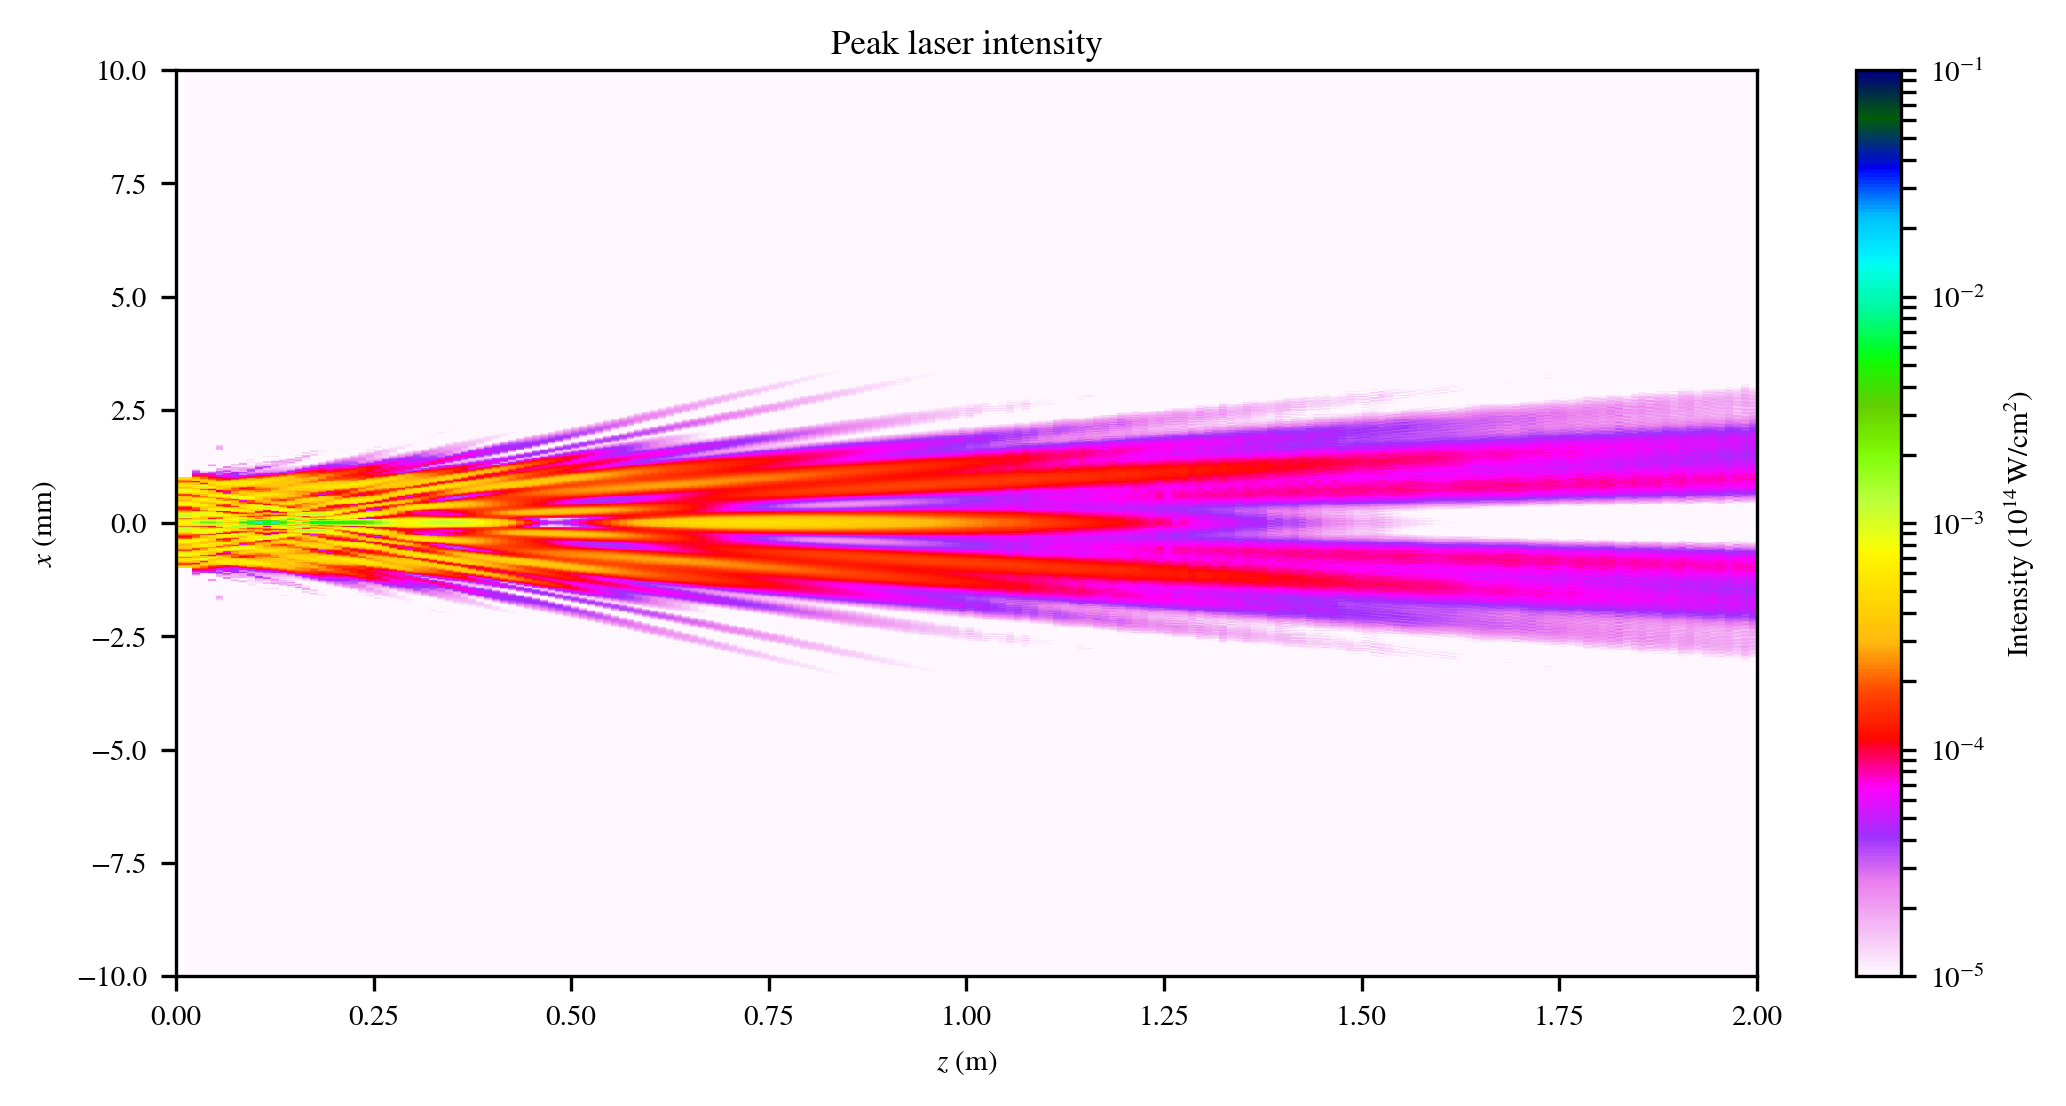

In [17]:
import matplotlib.colors as colors
plt.figure(figsize=(8.5, 4), dpi=300)
norm = colors.LogNorm(vmin=1e-5, vmax=0.1)
im = plt.imshow(I2, aspect='auto', extent=[0, Z/1e6, -pulse1.X/2e3, pulse1.X/2e3], norm=norm)
cb = plt.colorbar()
cb.set_label(r'Intensity ($10^{14}\,\mathrm{W/cm^2}$)')
plt.set_cmap('gist_ncar_r')
plt.xlabel(r'$z$ (m)')
plt.ylabel(r'$x$ (mm)')
plt.title('Peak laser intensity')
plt.show()